### First analysis of point sources around ALMA calibrators

In [6]:
import os , glob
import os.path as path
import pandas as pd

import matplotlib.pyplot as plt
from pylab import rcParams


import random
import numpy as np

from math import *
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix
import networkx as nx

## Constants
DEG2ARCSEC= 3600.

In [7]:
catdir =  "/home/stephane/Science/RadioGalaxy/DeepField/bosscha/analysis/catalog"
wdir = "/home/stephane/Science/RadioGalaxy/DeepField/bosscha/analysis/"

       sourceid       field          ra        dec  label   frequency  \
0             0  J0854+2006  133.715290  20.092024  Band3  107.512283   
1             1  J0854+2006  133.699518  20.111067  Band3  107.512283   
2             2  J0854+2006  133.703645  20.108511  Band3  107.512283   
3             3  J0854+2006  133.708043  20.106529  Band3  107.512283   
4             4  J0854+2006  133.707779  20.105954  Band3  107.512283   
...         ...         ...         ...        ...    ...         ...   
17564        22  J0532+0732   83.162467   7.546558  Band6  225.507170   
17565        23  J0532+0732   83.162494   7.545374  Band7  337.470864   
17566         0  J0348-2749   57.158938 -27.820436  Band3   95.825341   
17567         1  J0348-2749   57.158937 -27.820436  Band6  262.660323   
17568         2  J0348-2749   57.158936 -27.820435  Band7  344.794627   

           flux       rms  
0      0.002701  0.000397  
1      0.002831  0.000397  
2      2.429466  0.000397  
3      0.00

,sourceid,ra,dec,frequency,flux,rms
label,,,,,,
Band3,3172.814833,207.258056,-15.734007,97.744442,0.014120,0.000790
Band4,89.333333,183.494121,-1.640013,143.855139,0.753768,0.000132
Band6,556.049002,115.292962,-45.413583,162.655190,0.080505,0.000318
Band7,166.218750,143.037285,-24.217090,340.356788,0.536898,0.000143
Band8,1087.571429,187.216837,-14.746528,431.808082,1.609549,0.000698
Band9,941.437500,207.105858,-14.634202,667.490141,0.938454,0.000992


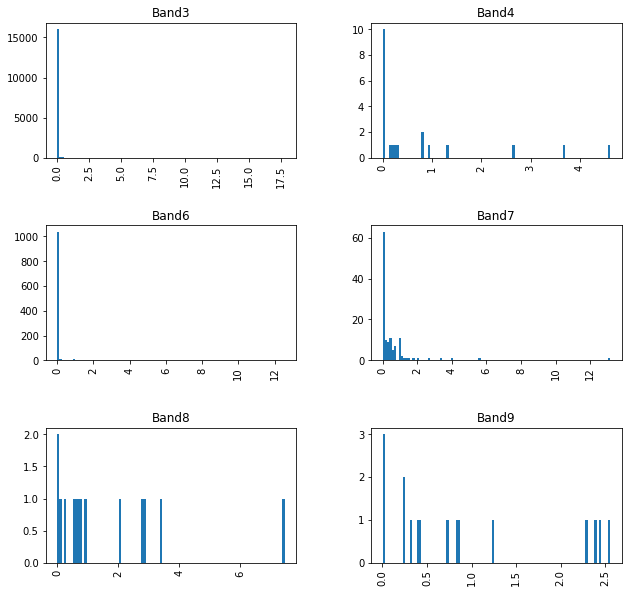

In [8]:
os.chdir(wdir)

## read the catalogues
catfile= glob.glob("%s/*.cat.csv"%(catdir))

dfcat= pd.read_csv(catfile[0])

for i in range(1,len(catfile)):
    df= pd.read_csv(catfile[i])
    dfcat= dfcat.append(df, ignore_index=True)
    
print(dfcat)
rcParams['figure.figsize'] = 10, 10

dfcat['flux'].hist(by=dfcat['label'], bins= 100)

print("##")
print("## Mean by band:")
dfcat.groupby('label').mean()


In [9]:
## counterparts

## find counterparts
##  
## ra, dec: array of all sources
## label: each source should have a different label
## 

class ctrprt:
    
    def __init__(self, ra, dec, label):
        self.ra= ra
        self.dec= dec
        self.label= label
        
    def setFlux(self, flux):
        self.flux= flux
              
    ## basic algorithm to connect one source at different frequencies.
    ## IMPORTANT: tolerance should be small enough to avoid two different sources at the "same" position
    def getGraphSource(self, tolerance= 0.5):
        K= []
        G=nx.Graph()
        tolerance /= DEG2ARCSEC
        
        for i in range(len(self.ra)):
            K.append([self.ra[i], self.dec[i]])
            G.add_node(i)
            dist= distance_matrix(K, K)
        
        
        pair= []
        for i in range(len(self.ra)):
            for j in range(i):
                if dist[i,j] < tolerance and self.label[i] != self.label[j]:
                    G.add_edge(i,j, weight= dist[i,j])
                    
        ## removing isolated nodes (detections)
        isol= list(nx.isolates(G))
        G.remove_nodes_from(list(nx.isolates(G)))
        
        return(G , isol)
    
    
    def getMultipleDetection(self, G):
        cont= True
        sources=[]
        
        if len(G.nodes) == 0:
            cont= False
        
        while cont:
            list_node= list(G.nodes)
            first_node= list_node[0]
            
            ## all nodes reachable from one node (same source)
            connected_nodes= list(nx.descendants(G,first_node))
            connected_nodes.append(first_node)
            connected_nodes.sort()
            
            sources.append(connected_nodes)
            
            for v in connected_nodes:
              G.remove_node(v)
            
            if len(G.nodes)==0:
                cont= False
        
        return(sources)

In [10]:
print("## look for counterparts...")

grp= dfcat.groupby("field")

for df in grp:
    print("## field: %s"%(df[0]))
    ra= df[1]['ra'].values.tolist()
    dec= df[1]['dec'].values.tolist()
    label= df[1]['label'].values.tolist()

    t = ctrprt(ra,dec,label)

    ## the parameter is the maximum distance in Arcsec to match 2 sources
    ## if the minimum distance is too large, it fails since it would pair two sources at the same frequency...
    g, isol= t.getGraphSource(0.5)  
    sources= t.getMultipleDetection(g)
    print(sources)


## look for counterparts...
## field: 3c454.3
[[0, 2, 4], [1, 3]]
## field: 4C_-02.55
[[0, 4], [1, 5, 7], [3, 6]]
## field: J0006-0623
[[0, 1, 2, 3, 4, 5]]
## field: J0040-3243
[[0, 1, 2]]
## field: J0108+0135
[]
## field: J0113+0222
[[0, 1, 2]]
## field: J0208-0047
[[1, 2, 3]]
## field: J0215-0222
[[0, 1, 2]]
## field: J0217+0144
[[0, 1, 2]]
## field: J0219+0120
[[0, 2, 3]]
## field: J0224+0659
[[0, 3, 4]]
## field: J0237+2848
[[9, 48], [10, 11, 51], [16, 59], [19, 66, 69], [21, 70], [22, 73, 122], [23, 28, 91], [27, 86], [29, 108, 109], [30, 74, 78]]
## field: J0238+1636
[[0, 4, 7, 8]]
## field: J0239-0234
[[0, 1, 2]]
## field: J0241-0815
[[0, 1, 3], [2, 4]]
## field: J0309+1029
[[0, 3, 7, 8, 9]]
## field: J0315-1656
[[0, 18, 37]]
## field: J0334-4008
[[0, 1, 2]]
## field: J0340-2119
[[0, 2, 3]]
## field: J0348-2749
[[0, 1, 2]]
## field: J0423-0120
[[1, 2, 3]]
## field: J0426+2327
[[0, 20]]
## field: J0438+3004
[[0, 2, 4]]
## field: J0501-0159
[[0, 1, 2]]
## field: J0506-6109
[[0, 2,

[[3560, 3621, 3625, 3642, 3650, 3660, 3667, 3681, 3694, 3713, 3714, 3715, 3743, 3749, 3751, 3755, 3813, 3818, 3819, 3822, 3829, 3831, 3847, 3881, 3885, 3890, 3910, 3911, 3916, 3917, 3923, 3932, 3941, 3956, 3966, 3981, 3987, 3989, 4006, 4021, 4045, 4063, 4072, 4074, 4075, 4087, 4093, 4094, 4106, 4107, 4116, 4118, 4131, 4137, 4152, 4153, 4162, 4189, 4191, 4209, 4243, 4247, 4255, 4256, 4258, 4261, 4265, 4269, 4275, 4280, 4288, 4297, 4301, 4305, 4330, 7771, 7772, 7773, 7774]]
## field: J1550+0527
[[0, 1, 2, 3]]
## field: J1625-2527
[[64, 85, 94, 101, 102, 103, 107, 124, 215, 216, 217]]
## field: J1626-2951
[[0, 1, 2, 3, 4]]
## field: J1700-2610
[[0, 1, 2]]
## field: J1717-3342
[[0, 1, 2]]
## field: J1733-1304
[[0, 2], [1, 3, 4]]
## field: J1744-3116
[[0, 2, 4]]
## field: J1751+0939
[]
## field: J1752-2956
[[0, 1, 2]]
## field: J1833-2103
[[71, 138], [136, 142, 144], [140, 141, 145]]
## field: J1924-2914
[[0, 4, 7]]
## field: J2035+1056
[[0, 1, 2]]
## field: J2056-4714
[[0, 1, 2]]
## field: